#Introduction



Financial reports are often complex and difficult to understand for non-experts. They’re long, filled with technical language and dense financial data, making it hard for students or everyday users to extract key insights. To solve this, we built an AI-powered tool that reads financial reports, summarizes important sections using large language models, and visualizes key figures like revenue and profit. Prompt engineering—the process of carefully designing inputs to guide model outputs— is used to tailor summaries for different audiences. The tool is lightweight, free, and easy to use—combining summarization and visualization to make financial information more accessible, understandable, and useful for anyone, regardless of their background.

This notebook demonstrates a generative AI pipeline for analyzing financial documents:

1. Upload a PDF-based financial report.
2. Automatically extract the text.
3. Summarise the content using advanced prompting strategies (Zero-shot, Few-shot, Chain-of-Thought, Tree-of-Thought).
4. Evaluate the quality of generated summaries using BLEU, ROUGE, and BERTScore.
5. Use an instruction-tuned language model (FLAN-T5) to suggest visualisations based on the summary.
6. Automatically render visual charts (bar, pie, line).
7. Chatbot for interactivity.

The goal is to showcase how prompting, summarisation, evaluation, and AI-assisted data storytelling can be combined into a single, interactive experience.



# Prompt-Driven Summarization, Visualization, and Interactive Insight Generation with Generative AI



##1. Upload & Extract PDF Report



This section, allows the user to upload a financial report in PDF format. The text content of the uploaded file is extracted using PyPDF2, and will later be used for summarisation and analysis.

In [ ]:
!pip install PyPDF2
import PyPDF2
import ipywidgets as widgets
from IPython.display import display
import io

# Creating an upload control
upload = widgets.FileUpload(accept='.pdf', multiple=False)
display(upload)

FileUpload(value={}, accept='.pdf', description='Upload')

## 2. Read Uploaded PDF

This function reads the PDF uploaded above, extracts text from all pages, and returns the full content. The result is stored as the financial text, which will be the input for summarisation.

In [ ]:
# --- Transcription ---
# Extract uploaded PDF content
def get_pdf_text(uploaded_file):
    content = uploaded_file[list(uploaded_file.keys())[0]]['content']
    reader = PyPDF2.PdfReader(io.BytesIO(content))
    text = ""
    for page in reader.pages:
        page_text = page.extract_text()
        if page_text:
            text += page_text
    return text

# Waiting for users to upload
def read_uploaded_pdf(upload_widget):
    while not upload_widget.value:
        pass
    return get_pdf_text(upload_widget.value)

# Perform upload and read PDF text
pdf_text = read_uploaded_pdf(upload)
transcript = pdf_text

In [ ]:
# Print the total word count of the extracted document.
print("Transcript word count:", len(transcript.split()))

Transcript word count: 282


In [ ]:
# Display a snippet of the full content for verification.
print(transcript)

NovaTech Ltd. - Q1 2025 Financial Report
1. Executive Summary
NovaTech Ltd., a mid-sized technology solutions provider, reported solid performance in Q1 2025. Revenue
increased by 12% year-over-year, driven by strong demand in cloud services and enterprise AI integration.
Net profit rose modestly due to increased operating expenses and R&D investments.
2. Key Financial Highlights
Metric Q1 2025 Q1 2024 Change (%)
Revenue £42.3 million £37.7 million +12.2%
Gross Profit £25.6 million £22.8 million +12.3%
Operating Expenses £17.1 million £14.9 million +14.8%
Operating Income £8.5 million £7.9 million +7.6%
Net Income £6.1 million £5.6 million +8.9%
EPS (Basic) £0.31 £0.28 +10.7%
Cash and Equivalents £18.2 million £14.6 million +24.7%
R&D Investment £4.2 million £3.5 million +20.0%
3. Business Segment Overview
Cloud & Infrastructure
Revenue: £19.3 million (+14.5% YoY)
Key growth from small-to-mid business clients migrating to NovaCloud 2.0
Gross margin: 61%
AI & Data Services
Revenue: £14.

## 3. Install and Import Summarisation Tools

Using Hugging Face Transformers (DistilBART) to perform abstractive summarisation and installing metrics packages for evaluation (bleu, rouge, bert score)

In [ ]:
!pip install rouge_score
!pip install bert_score
from transformers import pipeline
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import bert_score
from pprint import pprint

# Initialize summarizer
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")
smooth_fn = SmoothingFunction().method1

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6962c3d89ee2f2a6f35bb79617b266284f752072899211a1b835c04921a869b4
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

ModuleNotFoundError: No module named 'bert_score'

## 4. Define Prompt Templates

Defining four prompting strategies to explore the most effective prompt style：
- Zero-shot: Ask the model to summarise directly without any context.
- Few-shot: Provide a few example inputs and summaries.
- Chain-of-Thought: Break down the summary process into reasoning steps.
- Tree-of-Thought: Encourage hierarchical thinking — extracting trends, risks, and actions.

In [ ]:
# Create different styles of prompt
prompt_templates = {
    "zero_shot": [
        "Summarize the following financial report:\n\n{}",
        "Please provide a concise summary of the financial content below:\n\n{}",
        "Give an executive summary of this financial report:\n\n{}"
    ],
    "few_shot": [
        "Report: Revenue increased by 15%. Summary: Strong revenue growth.\n\nReport: {}\nSummary:",
        "Report: Operating expenses decreased 5% year-over-year. Summary: Cost control improvement.\n\nReport: {}\nSummary:",
        "Report: Cash flow turned positive in Q3. Summary: Improved liquidity.\n\nReport: {}\nSummary:"
    ],
    "chain_of_thought": [
        "Let's analyze step by step:\n1. Identify financial highlights.\n2. Note key changes in revenue, expenses, and profit.\n3. Summarize:\n\n{}",
        "Step-by-step financial summary:\nRevenue trends:\nExpense trends:\nProfit insights:\nOverall summary:\n\n{}",
        "Break down the report into key metrics and trends, then summarize:\n\n{}"
    ],
    "tree_of_thought": [
        "Financial Report:\n{}\nThought: Focus on revenue, profit, and strategic commentary.\nSummary:",
        "Financial Report:\n{}\nThought: Extract financial performance indicators and management insights.\nSummary:",
        "Financial Report:\n{}\nThought: Identify trends, risks, and opportunities.\nSummary:"
    ]
}


In [ ]:
# Create reference summary (self-summarised in advance)
reference = (
    "NovaTech Ltd. reported strong Q1 2025 financial results, with revenue rising 12.2% year-over-year to £42.3 million, driven by demand for cloud infrastructure and AI services. Despite a 14.8% increase in operating expenses—largely from expanded R&D—net income rose 8.9% to £6.1 million, and EPS reached £0.31. Cash reserves grew by 24.7%.Cloud & Infrastructure led segment growth, with a 14.5% revenue increase fueled by SME adoption of NovaCloud 2.0. AI & Data Services and Enterprise Software also saw solid growth, particularly in retail, healthcare, and remote workforce tools.On the balance sheet, NovaTech maintains a strong position with a current ratio of 2.4 and a debt-to-equity ratio of 0.45. Strategic initiatives included the launch of NovaCloud 2.0, an AI-focused acquisition, and a logistics partnership in Germany.Looking ahead, Q2 revenue is projected at £45–47 million, with increased marketing investment aimed at supporting expansion across Europe.")

## 5. Generate Summaries with Prompting Strategies

Looping through each prompt type and applying it to the full transcript. Each prompt is sent to the DistilBART model, which returns an abstractive summary.

In [ ]:
# Generate a summary for each prompt
results = {}
for style, prompts in prompt_templates.items():
    print(f"\n Generating for style: {style.upper()}")
    summaries = []
    for i, template in enumerate(prompts):
        prompt = template.format(transcript)
        try:
            summary = summarizer(prompt, max_length=130, min_length=30, do_sample=False)[0]["summary_text"]
            summaries.append(summary)
            print(f"Prompt {i+1} summary:\n{summary[:200]}...\n")
        except Exception as e:
            print(f"Error on {style} prompt {i+1}: {e}")
    results[style] = summaries



 Generating for style: ZERO_SHOT
Prompt 1 summary:
 Revenue increased by 12% year-over-year, driven by strong demand in cloud services and enterprise AI integration . Net profit rose modestly due to increased operating expenses and R&D investments ....

Prompt 2 summary:
 Revenue increased by 12% year-over-year, driven by strong demand in cloud services and enterprise AI integration . Net profit rose modestly due to increased operating expenses and R&D investments . N...

Prompt 3 summary:
 Revenue increased by 12% year-over-year driven by strong demand in cloud services and enterprise AI integration . Net profit rose modestly due to increased operating expenses and R&D investments ....


 Generating for style: FEW_SHOT
Prompt 1 summary:
 NovaTech Ltd. reported solid performance in Q1 2025 . Revenue increased by 12% year-over-year . Net profit rose modestly due to increased operating expenses and R&D investments ....

Prompt 2 summary:
 NovaTech Ltd. reported solid performance in Q1 2

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Prompt 1 summary:
 NovaTech Ltd. reported solid performance in Q1 2025 . Revenue increased by 12% year-over-year, driven by strong demand in cloud services and enterprise AI integration . Net profit rose modestly due t...

Prompt 2 summary:
 NovaTech Ltd. reported solid performance in Q1 2025 . Revenue increased by 12% year-over-year driven by strong demand in cloud services and enterprise AI integration . Net profit rose modestly due to...

Prompt 3 summary:
 Revenue increased by 12% year-over-year, driven by strong demand in cloud services and enterprise AI integration . Net profit rose modestly due to increased operating expenses and R&D investments . N...



## 6. Define and Implement Evaluation Function

This function calculates evaluation metrics between generated summaries and the reference.

In [ ]:
# - BLEU: n-gram overlap
# - ROUGE-L: longest common subsequence
# - BERTScore (F1): semantic similarity using embeddings

# Define the evaluation function
def evaluate_summary_set(generated_summaries, reference_text):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    eval_result = {"BLEU": 0, "ROUGE-L": 0, "BERTScore (F1)": 0}
    count = 0

    for pred in generated_summaries:
        try:
            bleu = sentence_bleu([reference_text.split()], pred.split(), smoothing_function=smooth_fn)
            rouge_l = scorer.score(reference_text, pred)["rougeL"].fmeasure
            P, R, F1 = bert_score.score([pred], [reference_text], lang="en", verbose=False)

            eval_result["BLEU"] += bleu
            eval_result["ROUGE-L"] += rouge_l
            eval_result["BERTScore (F1)"] += F1[0].item()
            count += 1
        except Exception as e:
            print(f"Evaluation failed on one summary: {e}")

    # Average rating
    for key in eval_result:
        eval_result[key] = round(eval_result[key] / count, 4) if count > 0 else -1
    return eval_result

In [ ]:
# Implementation evaluation
evaluation_scores = {}
for style, summaries in results.items():
    print(f"\n Evaluating summaries for {style.upper()}")
    evaluation_scores[style] = evaluate_summary_set(summaries, reference)


 Evaluating summaries for ZERO_SHOT


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Evaluating summaries for FEW_SHOT


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Evaluating summaries for CHAIN_OF_THOUGHT


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Evaluating summaries for TREE_OF_THOUGHT


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 7. Evaluate Summary Quality

Applying the above metrics across each prompting strategy and display the average scores.

In [ ]:
# Print results
print("\n Evaluation Scores (Average across 3 prompts):")
pprint(evaluation_scores)


 Evaluation Scores (Average across 3 prompts):
{'chain_of_thought': {'BERTScore (F1)': 0.8786,
                      'BLEU': 0.0029,
                      'ROUGE-L': 0.2164},
 'few_shot': {'BERTScore (F1)': 0.8774, 'BLEU': 0.0033, 'ROUGE-L': 0.2141},
 'tree_of_thought': {'BERTScore (F1)': 0.8799,
                     'BLEU': 0.0027,
                     'ROUGE-L': 0.2019},
 'zero_shot': {'BERTScore (F1)': 0.8719, 'BLEU': 0.001, 'ROUGE-L': 0.188}}


The performance of four prompting strategies—zero-shot, few-shot, chain-of-thought, and tree-of-thought—was evaluated using BERTScore (F1), BLEU, and ROUGE-L metrics. Overall, chain-of-thought prompting achieved the highest ROUGE-L score (0.2164) and a strong BERTScore F1 (0.8786), indicating its effectiveness in capturing salient content with fluent structure. Tree-of-thought prompting yielded the highest BERTScore (0.8799) but had a slightly lower ROUGE-L (0.2019), suggesting semantic richness but less overlap with reference phrasing. Few-shot prompting produced balanced results, while zero-shot prompting underperformed across all metrics, particularly in BLEU (0.001), highlighting its limitations in this domain-specific summarization task.

## 8. Generate Visualization Suggestions

This chunk passes the best summary — selected from earlier evaluations — into the FLAN-T5-Large model to generate relevant chart suggestions.

The Chain-of-Thought (CoT) summary was used as input because:
- It achieved the highest ROUGE-L score (0.2164), indicating the best alignment with reference content.

- It maintained strong semantic accuracy with a BERTScore F1 of 0.8786.

- Compared to other strategies (zero-shot, few-shot, tree-of-thought), CoT offered the most coherent and content-rich summary, making it ideal for downstream prompt-driven tasks like visualization generation.

In [ ]:
# Visualization Suggestions using FLAN-T5-Large (lightweight, instruction-following)
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Load model and tokenizer
model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

# Use the best summary (chain of thought)
best_summary = results["chain_of_thought"][0] if results["chain_of_thought"] else transcript[:800]

# Construct a clear prompt with few-shot example to guide output
prompt_text = f"""
You are a financial data analyst. Based on the summary below, suggest 3 useful data visualizations.
Mention the chart type and what it should show.

Example:
Summary: ABC Corp reported $5B revenue, $1B profit.
Visualizations:
1. Line chart showing revenue over quarters
2. Bar chart comparing revenue vs profit
3. Pie chart showing product-wise revenue distribution

Now do the same for this:
{best_summary}
"""

# Generate suggestions
inputs = tokenizer(prompt_text.strip(), return_tensors="pt", truncation=True).to(device)
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=150,
        temperature=0.7,
        num_beams=4,
        repetition_penalty=1.2
    )

visualization_suggestions = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Show output
print("\n Best Summary (used for visualization prompting):\n")
print(best_summary)
print("\n Suggested Visualizations (FLAN-T5-Large):\n")
print(visualization_suggestions)


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(



 Best Summary (used for visualization prompting):

 NovaTech Ltd. reported solid performance in Q1 2025 . Revenue increased by 12% year-over-year driven by strong demand in cloud services and enterprise AI integration . Net profit rose modestly due to increased operating expenses and R&D investments .

 Suggested Visualizations (FLAN-T5-Large):

1. Line chart showing revenue over quarters 2. Bar chart comparing revenue vs profit 3. Pie chart showing product-wise revenue distribution


## 9. Render Suggested Charts

This chunk uses the chart suggestions parsed in Chunk 8 (from FLAN-T5-Large output based on the Chain-of-Thought summary) to generate actual visualizations using real NovaTech Q1 2025 data. The cleaned suggestions (e.g., line, bar, pie charts) are matched to specific chart types.


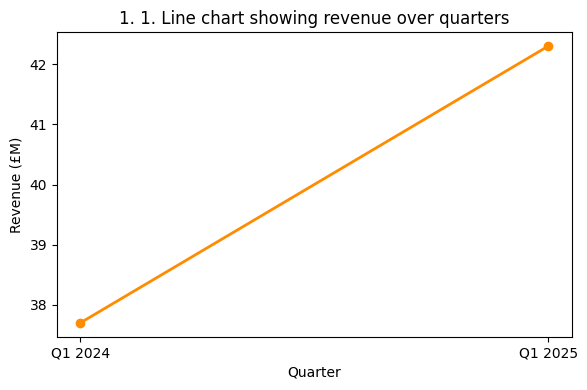

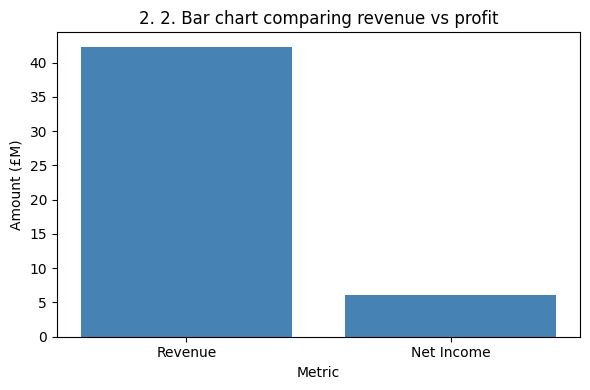

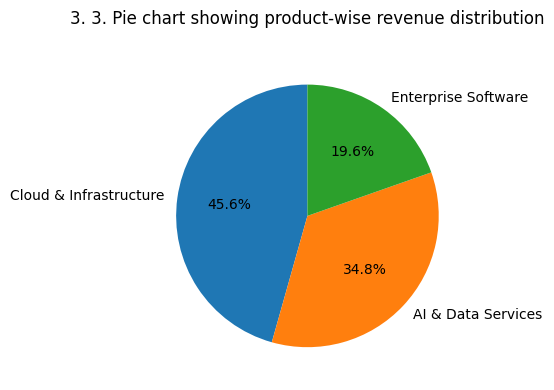

In [ ]:
import re
import matplotlib.pyplot as plt

# === STEP 1: Extract clean chart descriptions from FLAN output ===
chart_descriptions = re.findall(r'\d+\.\s[^1-9]+?(?=\d+\.|$)', visualization_suggestions)
chart_descriptions = [desc.strip() for desc in chart_descriptions]

# === STEP 2: Render each chart based on type and real NovaTech values ===
if chart_descriptions:
    for idx, desc in enumerate(chart_descriptions, 1):
        desc_lower = desc.lower()
        plt.figure(figsize=(6, 4))

        # Pie chart: Revenue share across Cloud, AI, and Software segments
        if "pie" in desc_lower:
            # Real values: Segment-wise revenue
            labels = ["Cloud & Infrastructure", "AI & Data Services", "Enterprise Software"]
            values = [19.3, 14.7, 8.3]  # in £M
            plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
            plt.title(f"{idx}. {desc}", pad=20)

        # Bar chart: Comparison of revenue vs net income
        elif "bar" in desc_lower:
            if "revenue vs profit" in desc_lower or "revenue vs net income" in desc_lower:
                labels = ["Revenue", "Net Income"]
                values = [42.3, 6.1]  # in £M
            else:
                labels = ["Cloud", "AI", "Software"]
                values = [19.3, 14.7, 8.3]
            plt.bar(labels, values, color="steelblue")
            plt.xlabel("Metric")
            plt.ylabel("Amount (£M)")
            plt.title(f"{idx}. {desc}")

        # Line chart: Revenue growth from Q1 2024 to Q1 2025
        else:
            # Real values: Q1 2024 vs Q1 2025 revenue
            x = ["Q1 2024", "Q1 2025"]
            y = [37.7, 42.3]
            plt.plot(x, y, marker='o', linewidth=2, color='darkorange')
            plt.xlabel("Quarter")
            plt.ylabel("Revenue (£M)")
            plt.title(f"{idx}. {desc}")

        plt.tight_layout()
        plt.show()
else:
    print(" No valid chart descriptions found in model output.")


# 10. Chatbot

This chunk pre-processes the raw transcript by converting everything to lowercase, removing any punctuation marks, and gets rid of extra spaces. Then `sentence-transformers/all-mpnet-base-v2` model is used to generate embeddings for this cleaned text. The idea here is to convert the text into a meaningful numerical representation that captures its semantic content. Then a `RobertaForFinancialChatbot` class is built, which is essentially a `RoBERTa` model with a couple of extra linear layers. Since, a single label is involved for the entire transcript, it is set up for a regression task using Mean Squared Error loss.

The `train_model` function takes the generated embeddings and this single label to fine-tune the model, although with just one data point. Finally a pre-trained question-answering model is used - specifically `distilbert-base-cased-distilled-squad` - to directly query the original transcript. This part allows for an interactive session where user can ask questions about the financial report, and the model will try to find and extract the answers. It's a way to see how a different type of NLP model handles understanding the text.

In [ ]:
#Pre-Processing raw text
import re

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

processed_transcript = preprocess_text(transcript)

print("Processed Transcript:")
print(processed_transcript)

Processed Transcript:
novatech ltd q1 2025 financial report 1 executive summary novatech ltd a midsized technology solutions provider reported solid performance in q1 2025 revenue increased by 12 yearoveryear driven by strong demand in cloud services and enterprise ai integration net profit rose modestly due to increased operating expenses and rd investments 2 key financial highlights metric q1 2025 q1 2024 change revenue 423 million 377 million 122 gross profit 256 million 228 million 123 operating expenses 171 million 149 million 148 operating income 85 million 79 million 76 net income 61 million 56 million 89 eps basic 031 028 107 cash and equivalents 182 million 146 million 247 rd investment 42 million 35 million 200 3 business segment overview cloud infrastructure revenue 193 million 145 yoy key growth from smalltomid business clients migrating to novacloud 20 gross margin 61 ai data services revenue 147 million 101 yoy strong traction in retail and healthcare sectors gross margin

In [ ]:
# Embedding the pre-processed text
import torch
from transformers import AutoTokenizer, AutoModel

# Loading pre-trained model and tokenizer
model_name = "sentence-transformers/all-mpnet-base-v2" # Example model, choose a suitable one
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def generate_embeddings(text):
  # Tokenizing the text
  inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")

  # Getting embeddings
  with torch.no_grad():
    embeddings = model(**inputs).pooler_output

  return embeddings


transcript_embeddings = generate_embeddings(processed_transcript)

print("Transcript Embeddings Shape:", transcript_embeddings.shape)

Transcript Embeddings Shape: torch.Size([1, 768])


In [ ]:
#Training the model
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel

class RobertaForFinancialChatbot(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, model_name="deepset/roberta-base-squad2", num_labels=1):
        super(RobertaForFinancialChatbot, self).__init__()
        self.roberta = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        # Here, we'll add a linear layer to adapt the output of RoBERTa to the hidden_dim and then to the final output
        self.linear1 = nn.Linear(self.roberta.config.hidden_size, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, num_labels)
        self.activation = nn.ReLU()  # Or any other suitable activation

    def forward(self, embeddings):
        # Pass embeddings through the linear layers
        x = self.linear1(embeddings)
        x = self.activation(x)
        x = self.linear2(x)
        return x

    def compute_loss(self, outputs, labels):
        loss_fn = nn.MSELoss()
        return loss_fn(outputs.squeeze(), labels)

def train_model(model, embeddings, labels, batch_size=32, epochs=5, learning_rate=1e-4):
    # Since we have a single transcript, we'll adjust the data loading
    dataset = TensorDataset(embeddings.unsqueeze(0), labels.unsqueeze(0))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        total_loss = 0
        for batch in dataloader:
            batch_embeddings = batch[0].to(device)
            batch_labels = batch[1].to(device).float() # Ensuring labels are float for MSELoss

            optimizer.zero_grad()
            outputs = model(batch_embeddings)
            loss = model.compute_loss(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Average Loss: {avg_loss:.4f}")

    print("Training finished!")


if __name__ == "__main__":

    example_label = torch.tensor([0.5])

    # Getting the embedding dimension from the computed embeddings
    embedding_dim = transcript_embeddings.shape[-1]
    hidden_dim = 128
    model = RobertaForFinancialChatbot(embedding_dim, hidden_dim)

    # Training the model
    train_model(model, transcript_embeddings, example_label, epochs=10) # Increased epochs for demonstration

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10
Average Loss: 0.2154
Epoch 2/10
Average Loss: 0.2076
Epoch 3/10
Average Loss: 0.2002
Epoch 4/10
Average Loss: 0.1932
Epoch 5/10
Average Loss: 0.1867
Epoch 6/10
Average Loss: 0.1805
Epoch 7/10
Average Loss: 0.1749
Epoch 8/10
Average Loss: 0.1698
Epoch 9/10
Average Loss: 0.1648
Epoch 10/10
Average Loss: 0.1602
Training finished!


In [ ]:
#Deploying the model and asking questions related to the file
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

# Instead of using your custom model, use a pre-trained question answering model
model_name = "distilbert-base-cased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

question_answerer = pipeline("question-answering", model=model, tokenizer=tokenizer)
while True:
    user_question = input("Ask a question about the financial report (or type 'exit'): ")
    if user_question.lower() == 'exit':
        break

    result = question_answerer(question=user_question, context=transcript)
    print(f"Question: {user_question}")
    print(f"Answer: {result['answer']}")
    print(f"Start: {result['start']}, End: {result['end']}, Score: {result['score']}")

Device set to use cuda:0


Ask a question about the financial report (or type 'exit'): What is the projected revenue for Q2 2025?
Question: What is the projected revenue for Q2 2025?
Answer: £45-47 million
Start: 1760, End: 1774, Score: 0.9328452944755554
Ask a question about the financial report (or type 'exit'): What is the expected increase in marketing spend to support European expansion?
Question: What is the expected increase in marketing spend to support European expansion?
Answer: 8%
Start: 1876, End: 1878, Score: 0.9809913635253906
Ask a question about the financial report (or type 'exit'): exit


# Limitations and Recommendations

While this project demonstrates how generative AI can be used to extract and summarise insights from financial documents, there are several limitations that affected the scope and level of automation we were able to achieve.

**Limitations**

One of the main constraints was the use of Google Colab’s free tier, which limited the runtime, memory, and processing power available. This affected our ability to run larger models, execute visualisation code dynamically, and generally limited end-to-end automation.

Another issue is that while the model generates relevant visualisation suggestions from text summaries, the process stops there — it does not automatically create the actual charts. Full automation would require executing model-generated code, which isn’t currently supported safely in the chosen environment.

Additionally, the current pipeline only reads text and tables from uploaded PDFs. It does not process visual content such as graphs or embedded images, which are often used to communicate key financial metrics. As a result, the summaries miss important non-textual information that could affect interpretation.

The prompting strategies used (zero-shot, few-shot, chain-of-thought) work reasonably well, but they remain general in nature. They haven’t yet been tailored to the specific structure or semantics of financial reports, which affects the precision of the generated outputs.

**Improvements and Next Steps**

To take this project further, several enhancements could be introduced, both on the technical and design side:

*Infrastructure Upgrade*

Moving to a more powerful runtime environment (e.g. Colab Pro, AWS, or a managed GPU workspace) would open up access to larger models, better session reliability, and more flexibility to automate complex workflows like code execution and visual rendering.

*Automated Visualisation Pipeline*

We can extend the current model prompts to generate Python code for visualisations (e.g. bar charts, pie charts) using libraries like matplotlib or plotly, and automatically render these within the notebook. This would turn textual summaries into complete data narratives.

*Multimodal Processing*

To capture insights from charts and visuals embedded in financial reports, we could incorporate tools such as LayoutParser or Donut for layout-aware document parsing, and use OCR (e.g. Tesseract) or image captioning models to interpret images and graphs.

*Use of AI Agents for Orchestration*

Introducing lightweight AI agents could help coordinate different parts of the pipeline — for example, one agent could handle PDF parsing, another could manage summarisation, and a third could focus on generating and validating visualisations. This kind of orchestration allows for more scalable and modular processing, especially in enterprise scenarios.

*Task Sequencing and Flow Control*

Structuring the process as a multi-step pipeline — with clearly defined phases like extraction → summarisation → evaluation → visualisation — allows for more control and extensibility. Sequencing can also support conditional branching, e.g. only generating visualisations if a summary meets a certain confidence threshold.

*Validation Mechanisms*

Adding automated validation layers would help assess the quality of model outputs before they’re shown to users. This could include logic-based checks (e.g. ensuring the summary mentions all key sections of a financial report) or consistency checks across different summarisation strategies. Over time, feedback loops could be introduced to reinforce high-quality outputs.

*Domain-Aware Prompting*

Developing financial-report-specific prompts (e.g. “Summarise the key insights from the balance sheet section”) would make outputs more structured and relevant. These can be refined through experimentation or fine-tuned prompting frameworks.

*Incorporating RAG Techniques*

For longer documents, implementing Retrieval-Augmented Generation (RAG) would improve the model’s ability to maintain context and generate more coherent, factually grounded summaries.


Together, these improvements would move the project beyond a proof-of-concept into a more robust, scalable system that could be deployed in real-world financial analysis settings — supporting automation, reducing time to insight, and improving report comprehensibility.